<a href="https://colab.research.google.com/github/joaopcnogueira/colab-notebooks/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotnine

In [2]:
import numpy as np
import pandas as pd
from plotnine import *

# 1.0 Data Preparation

In [3]:
cdnow_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CDNOW_master.txt", 
                           sep="\s+", 
                           names = ["customer_id", "date", "quantity", "price"])
cdnow_raw_df.head()

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [5]:
cdnow_df = cdnow_raw_df \
  .assign(date = lambda x: x['date'].astype(str)) \
  .assign(date = lambda x: pd.to_datetime(x['date']))

In [6]:
cdnow_df.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [7]:
cdnow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


# 2.0 Cohort Analysis

Only the customers that have joined at the specific business day

In [8]:
# Get Range of Initial Purchases ----
cdnow_first_purchase_df = cdnow_df \
    .sort_values(['customer_id', 'date']) \
    .groupby('customer_id') \
    .first()

cdnow_first_purchase_df

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [9]:
cdnow_first_purchase_df.agg({'date': ['min', 'max']})

,date
min,1997-01-01
max,1997-03-25


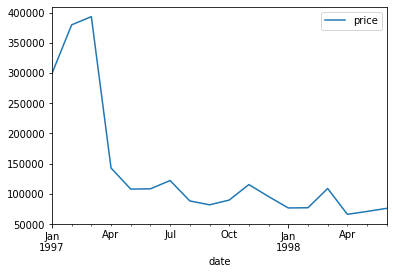

In [10]:
# Visualize: All purchases within cohort
cdnow_df \
  .reset_index() \
  .set_index('date') \
  .filter(['price']) \
  .resample(rule="MS") \
  .sum() \
  .plot()

In [11]:
# Visualize: Individual Customer Purchases
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

In [12]:
cdnow_cust_id_subset_df = cdnow_df \
    [cdnow_df['customer_id'].isin(ids_selected)] \
    .groupby(['customer_id', 'date']) \
    .sum() \
    .reset_index()

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)


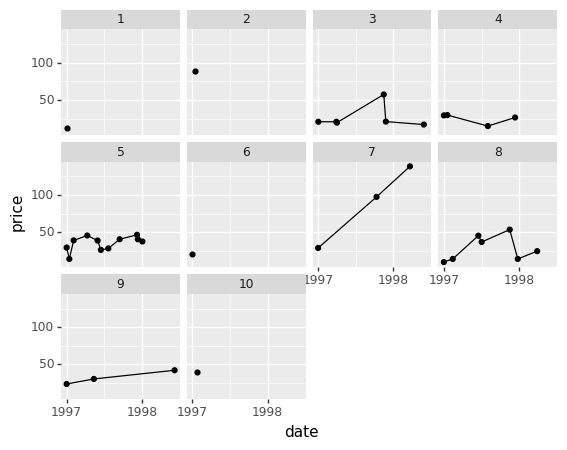

<ggplot: (8791328847477)>

In [13]:
ggplot(aes(x='date', y='price', group='customer_id'), data=cdnow_cust_id_subset_df) \
  + geom_line() \
  + geom_point() \
  + facet_wrap('customer_id') \
  + scale_x_date(
      date_breaks = "1 year",
      date_labels = "%Y"
  )

# 3.0 Machine Learning

Frame the problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in next 90-days? (Classification)

## 3.1 Time Splitting (Stage 1) 

In [14]:
n_days   = 90
max_date = cdnow_df['date'].max() 
cutoff   = max_date - pd.to_timedelta(n_days, unit = "d")

In [15]:
max_date

Timestamp('1998-06-30 00:00:00')

In [16]:
cutoff

Timestamp('1998-04-01 00:00:00')

In [17]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]

temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

## 3.2 Feature Engineering (RFM)
- Most challenging part
- 2-Stage Process
- Need to frame the problem
- Need to thing about what features to include

In [18]:
# Make Targets from out data ----
targets_df = temporal_out_df \
  .drop('quantity', axis=1) \
  .groupby('customer_id') \
  .sum() \
  .rename({'price': 'spend_90_total'}, axis = 1) \
  .assign(spend_90_flag = 1)
  
targets_df.head()

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1


In [19]:
# Make Recency (Date) Features from in data ----
max_date = temporal_in_df['date'].max()

recency_features_df = temporal_in_df \
  .filter(['customer_id', 'date']) \
  .groupby('customer_id') \
  .apply(lambda x: (max_date - x['date'].max()) / pd.to_timedelta(1, "day")) \
  .to_frame() \
  .set_axis(["recency"], axis=1)

In [20]:
recency_features_df.head()

,recency
customer_id,
1,455.0
2,444.0
3,127.0
4,110.0
5,88.0


In [21]:
# Make Frequency (Count) Features from in data ----
frequency_features_df = temporal_in_df \
    [['customer_id', 'date']] \
    .groupby('customer_id') \
    .count() \
    .set_axis(['frequency'], axis=1)

frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [22]:
# Make Price (Monetary) Features from in data ----
price_features_df = temporal_in_df \
    .groupby('customer_id') \
    .aggregate({'price': ["sum", "mean"]}) \
    .set_axis(['price_sum', 'price_mean'], axis = 1)

price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


## 3.3 Combine Features

In [28]:
features_df = pd.concat([recency_features_df, frequency_features_df, price_features_df], axis=1) \
  .merge(targets_df, left_index=True, right_index=True, how="left") \
  .fillna(0)

features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,455.0,1,11.77,11.770000,0.00,0.0
2,444.0,2,89.00,44.500000,0.00,0.0
3,127.0,5,139.47,27.894000,16.99,1.0
4,110.0,4,100.50,25.125000,0.00,0.0
5,88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,372.0,1,36.00,36.000000,0.00,0.0
23567,372.0,1,20.97,20.970000,0.00,0.0
23568,344.0,3,121.70,40.566667,0.00,0.0


In [29]:
features_df['spend_90_flag'].value_counts(1)

0.0    0.859949
1.0    0.140051
Name: spend_90_flag, dtype: float64

# 4.0 Machine Learning

In [30]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

## 4.1 Next 90-Day Spend Prediction

In [31]:
y_spend = features_df['spend_90_total']

xgb_reg_spec = XGBRegressor(
    objective="reg:squarederror",
    random_state=123
)

In [32]:
xgb_reg_model = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

In [33]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=123, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_t

In [34]:
xgb_reg_model.best_score_

-10.137374885981702

In [35]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [36]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [38]:
predictions_reg = xgb_reg_model.predict(X)

In [39]:
predictions_reg

array([1.7315966, 1.7897931, 6.5675673, ..., 2.1968884, 1.7315966,
       1.7897931], dtype=float32)

## 4.2 Next 90-Day Spend Probability

In [40]:
y_prob = features_df['spend_90_flag']

In [41]:
xgb_clf_spec = XGBClassifier(
    objective    = "binary:logistic",   
    random_state = 123
)

In [43]:
xgb_clf_model = GridSearchCV(
    estimator=xgb_clf_spec, 
    param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
    scoring='roc_auc',
    refit=True,
    cv=5
)

In [44]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [45]:
xgb_clf_model.best_score_

0.8388469885517397

In [46]:
xgb_clf_model.best_params_

{'learning_rate': 0.1}

In [47]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
predictions_clf = xgb_clf_model.predict_proba(X)

## 4.3 Feature Importance (Global)

In [58]:
# Importance: Spend Amount Model

imp_spend_amount_dict = xgb_reg_model \
  .best_estimator_ \
  .get_booster() \
  .get_score(importance_type = 'gain')

imp_spend_amount_dict

{'frequency': 600083.0900420168,
 'price_mean': 276415.6874,
 'price_sum': 2730946.44922807,
 'recency': 669314.0210261188}

In [67]:
imp_spend_amount_df = pd.Series(imp_spend_amount_dict) \
  .to_frame() \
  .set_axis(['feature_importance_reg'], axis=1) \
  .sort_values('feature_importance_reg', ascending=True)

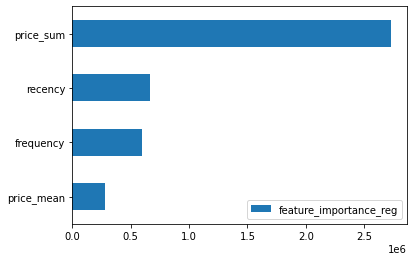

In [72]:
imp_spend_amount_df.plot.barh();

In [69]:
# Importance: Spend Probability Model

imp_spend_prob_dict = xgb_clf_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type='gain') 

imp_spend_prob_dict

{'frequency': 38.720339346008274,
 'price_mean': 2.928001695973554,
 'price_sum': 4.836309561134968,
 'recency': 85.68695001026333}

In [70]:
imp_spend_prob_df = pd.Series(imp_spend_prob_dict) \
  .to_frame() \
  .set_axis(['feature_importance_clf'], axis=1) \
  .sort_values('feature_importance_clf', ascending=True)

imp_spend_prob_df

,feature_importance_clf
price_mean,2.928002
price_sum,4.836310
frequency,38.720339
recency,85.686950


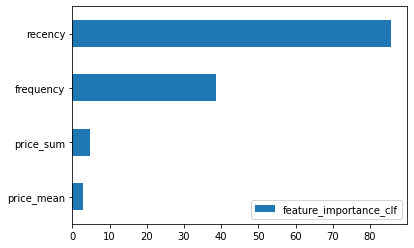

In [71]:
imp_spend_prob_df.plot.barh();

# 5.0 Making Predictions

In [78]:
predictions_df = features_df \
  .assign(pred_spend = predictions_reg) \
  .assign(pred_prob  = predictions_clf[:, 1]) \
  .reset_index()

In [79]:
predictions_df

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_prob
0,1,455.0,1,11.77,11.770000,0.00,0.0,1.731597,0.024034
1,2,444.0,2,89.00,44.500000,0.00,0.0,1.789793,0.036890
2,3,127.0,5,139.47,27.894000,16.99,1.0,6.567567,0.294515
3,4,110.0,4,100.50,25.125000,0.00,0.0,5.892581,0.288133
4,5,88.0,11,385.61,35.055455,0.00,0.0,21.155424,0.563635
...,...,...,...,...,...,...,...,...,...
23565,23566,372.0,1,36.00,36.000000,0.00,0.0,1.731597,0.037670
23566,23567,372.0,1,20.97,20.970000,0.00,0.0,1.731597,0.038869
23567,23568,344.0,3,121.70,40.566667,0.00,0.0,2.196888,0.099602
23568,23569,372.0,1,25.74,25.740000,0.00,0.0,1.731597,0.045040


# 6.0 How Can We Use The Predictions

## 6.1 Which customers have the highest spend probability in next 90-days?
- Target for new products similar to what they have purchased in the past

In [80]:
predictions_df \
  .sort_values('pred_prob', ascending=False)

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_prob
709,710,2.0,51,2216.45,43.459804,285.85,1.0,153.482727,0.971258
7591,7592,2.0,165,11478.02,69.563758,2512.91,1.0,1001.350464,0.971258
14047,14048,0.0,180,7267.15,40.373056,1709.18,1.0,1001.350464,0.970961
3048,3049,1.0,97,3484.03,35.917835,778.82,1.0,440.319794,0.968814
498,499,3.0,100,3427.55,34.275500,951.00,1.0,440.319794,0.966508
...,...,...,...,...,...,...,...,...,...
1482,1483,450.0,1,163.52,163.520000,0.00,0.0,3.860115,0.006407
1349,1350,450.0,1,156.00,156.000000,0.00,0.0,3.860115,0.006407
1393,1394,450.0,1,209.96,209.960000,0.00,0.0,4.560120,0.006407
1284,1285,450.0,1,116.73,116.730000,0.00,0.0,1.955996,0.006391


## 6.2 Which customers have recently purchased but are unlikely to buy?

- Incentivize actions to increase probability
- Provide discounts, encourage referring a friend, nurture by letting them know what's coming

In [85]:
predictions_df \
  [predictions_df['recency'] < 90] \
  [predictions_df['pred_prob'] < 0.20] \
  .sort_values('pred_prob', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_prob
18044,18045,47.0,2,167.82,83.910,0.00,0.0,9.545571,0.197904
20162,20163,86.0,2,86.86,43.430,39.16,1.0,6.441297,0.197458
1408,1409,69.0,3,34.32,11.440,0.00,0.0,6.623992,0.196389
8931,8932,22.0,2,183.59,91.795,0.00,0.0,10.245576,0.195975
8507,8508,59.0,2,126.90,63.450,39.47,1.0,7.242431,0.195953
...,...,...,...,...,...,...,...,...,...
15248,15249,8.0,2,241.92,120.960,0.00,0.0,12.126535,0.116030
4090,4091,62.0,2,294.71,147.355,0.00,0.0,11.338530,0.114049
980,981,11.0,2,308.38,154.190,0.00,0.0,13.435866,0.109629
14449,14450,64.0,2,202.88,101.440,0.00,0.0,9.337772,0.108266


## 6.3 Missed oportunities: big spenders that could be unlocked

- Send bundle offers encouraging volume purchases
- Focus on missed opportunities

In [87]:
predictions_df \
  [predictions_df['spend_90_total'] == 0] \
  .sort_values('pred_spend', ascending=False)

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,pred_prob
21684,21685,14.0,25,2031.06,81.242400,0.0,0.0,153.482727,0.710493
17522,17523,5.0,17,2280.08,134.122353,0.0,0.0,132.530075,0.808271
20943,20944,18.0,15,1554.08,103.605333,0.0,0.0,94.241707,0.657206
1160,1161,10.0,11,1244.34,113.121818,0.0,0.0,94.241707,0.842631
1589,1590,19.0,11,1327.23,120.657273,0.0,0.0,94.241707,0.736050
...,...,...,...,...,...,...,...,...,...
5727,5728,433.0,1,40.46,40.460000,0.0,0.0,1.731597,0.026418
5726,5727,346.0,2,39.67,19.835000,0.0,0.0,1.731597,0.090848
13595,13596,407.0,1,12.77,12.770000,0.0,0.0,1.731597,0.032175
0,1,455.0,1,11.77,11.770000,0.0,0.0,1.731597,0.024034
